# 1. Introduction
In this example we define a simple toy model to test see if methods like Random Forest are at all suitable to remove seasonality effects. The basic 'trick' is to add the seasonality as a feature to the model

## 1.1. The Toy model
Assume you have a time series of $N$ shops which reports a total number of shoppers $S_i(t)$ where $t$ is that day and $i$ is a specific shop. On certain dates $T_j(t)$, where $i$ stands for a specific shop and $j$ stands for a specific date for that shop we conduct a special campaign where shoppers receive certain items with a total amount $D_{i, j}$ for free. Assuming this leads to ramped up demand before and after the campaign we model this with the toy model below
\begin{align}
S_i(t) = r_i(t) + \sum_j D_{ij} \exp{\dfrac{\left(t-T_{ij}\right)^2}{\sigma^2}}  \ .
\end{align}
We observe $S_i(t)$ of this time series, but our goal is to get a resonable estimate, even during the period where we see ramped up demand.









## 1.2. Toy data simulation
Lets assume we do this campaign on the last day in March and September. Lets create a table for a single shop with the columns
date/amount/


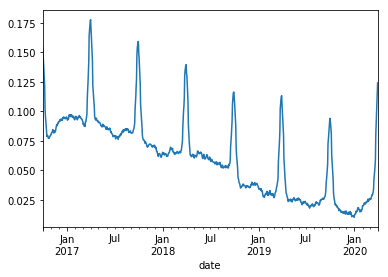

In [69]:
import pandas as pd
import numpy as np
np.random.seed(200)

def add_events():
    dates = pd.bdate_range('2016-07-01', '2020-08-22')
    df = pd.DataFrame(dates, columns=['date'])
    emonths = (df['date'].dt.month.shift(-1) != df['date'].dt.month) &\
              (df['date'].dt.month.isin([3, 9]))
    df.loc[:, 'D'] = 0.0
    df.loc[emonths, 'D'] = np.random.uniform(0.5, 1, emonths[emonths].shape[0])
    return df

def add_randomwalk(df):
    df.loc[:, 'r'] = (0.001*np.random.randn(df.shape[0])).cumsum()
    df.loc[:, 'r'] = df['r'] + abs(df['r'].min()) + 0.01
    return df

def add_eventgrid(df):
    evdates = df.loc[df['D'] > 0].reset_index(drop=True)
    for i, row in evdates.iterrows():
        df.loc[:, 'event'+str(i)] = (row['date'] - df['date']).dt.days
    return df

def add_seasonal_peaks(df, sigma=1e03):
    ecols = df.columns[df.columns.str.contains('event')]
    df.loc[:, 'seasonal'] = 0
    ds = df.loc[df['D']>0, 'D'].tolist()
    for i, col in enumerate(ecols):
        seasonal = np.exp(- np.power(df.loc[:, col],2)/sigma)
        df.loc[:, 'seasonal'] += 0.1*ds[i]*seasonal
    df.loc[:, 'S'] = df['r'] + df['seasonal']
    return df

def add_prev_next_event_features(df):
    evdates = df.loc[df['D']>0, ['date', 'D']]
    df = pd.merge_asof(df, evdates.assign(next_event_date=lambda x:x['date'],
                                          next_D = lambda x:x['D'])\
                                  .drop('D', axis=1),
                       on='date', direction='forward',
                       allow_exact_matches=False)
    df = pd.merge_asof(df, evdates.assign(prev_event_date=lambda x:x['date'],
                                          prev_D = lambda x:x['D'])\
                                  .drop('D', axis=1),
                       on='date')
    df.loc[:, 'next_event_days'] = (df['date'] - df['next_event_date']).dt.days
    df.loc[:, 'prev_event_days'] = (df['date'] - df['prev_event_date']).dt.days
    return df

def make_shop(seedno=0):
    np.random.seed(seedno)
    df = add_events()
    df = add_randomwalk(df)
    df = add_eventgrid(df)
    df = add_seasonal_peaks(df, sigma=1e02)
    df = add_prev_next_event_features(df)
    df = df.dropna().assign(shopno=seedno)
    return df

df = make_shop()
df.set_index('date')['S'].plot()

In [70]:
%%time
df = pd.concat([make_shop(i) for i in range(1300)])

Wall time: 1min 44s


# 1.3 Fitting a Model to remove the seasonality
After creating our mock data we would like to see if we can fit a model that explains the part which is explainable by the campaign event amount, as well as the distance to campaign event. Conceptionally we would like to fit a function and then subtract that function from the observed value, hoping that the so attained residual contains the de-seasonalized amount

## 1.3.1 The goals of fitting
Please note that we have 2 goals here. The first goal is to find historically how much of the signal can be explained by the feature columns

fcols = ['next_D', 'prev_D', 'next_event_days', 'prev_event_days'].

The other question is if we can in a forecasting scenario attribute a certain contribution to seasonality and the rest to something else. We will first start out with the first goal


## 1.3.2 Fitting a Random Forest

In [71]:
fcols = ['next_D', 'prev_D', 'next_event_days', 'prev_event_days']

In [72]:
traindf = df.query('date > "2017-01-01"')
X_train = traindf.loc[:, fcols].values
y_train = traindf.loc[:, 'S']

In [73]:
%%time
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10,
                                random_state=2, n_jobs=-2)
rf.fit(X_train, y_train)

Wall time: 1min 38s


In [74]:
traindf.loc[:, 'pS'] = rf.predict(X_train)
traindf.loc[:, 'pr'] = traindf['S'] - traindf['pS'] + traindf['pS'].median()
from sklearn.metrics import r2_score
r2_score(traindf['pr'], traindf['r'])

C:\Users\Pawlovicky\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Pawlovicky\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.9927962781571628

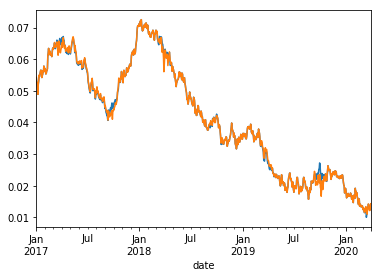

In [75]:
xtest = df.query('(date > "2017-01-01") & (shopno == 2)')\
          .loc[:, fcols]
ytest = df.query('(date > "2017-01-01") & (shopno == 2)')\
          .loc[:, ['date', 'S', 'r']].reset_index(drop=True)

testd = pd.concat([pd.DataFrame(rf.predict(xtest.values),
                                columns=['pS']), ytest],
          axis=1)
testd.loc[:, 'pr'] = testd['S'] - testd['pS'] + testd['pS'].median()
testd.loc[:, 'pr - r'] = (testd['pr'] - testd['r'])/testd['r']
testd.set_index('date')['r'].plot()
testd.set_index('date')['pr'].plot()

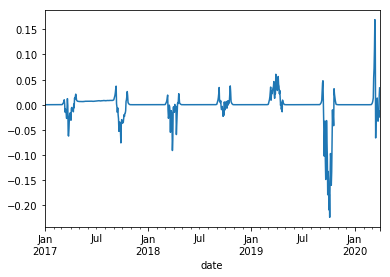

In [76]:
testd.set_index('date')['pr - r'].plot()

# 1.3.3 Conclusion
I think it is fair to say it is quite impressive how well the random forest picks up and is able to remove the seasonality effect. We get an $R^2$ of 0.99. For the period where the seasonality is active, we get some sizeable error, on the order of a 1-10% of the original value. The obvious concern about this approach is that realistically the seasonality function will not be deterministic, sigma may depend on the shop as well as on t.

# 2.0 Out of sample attribution